In [12]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd
from skimage.metrics import structural_similarity as ssim

In [3]:
img = cv2.imread("lenna.png")

In [4]:
print(img.shape)

(512, 512, 3)


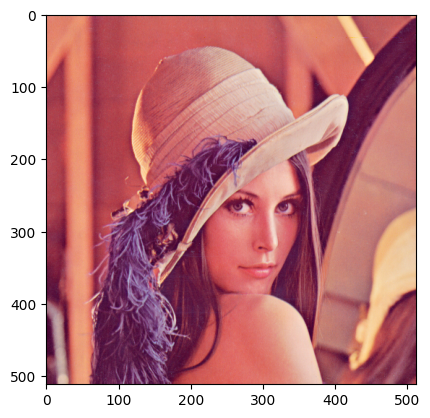

In [5]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [2]:
def text_to_binary(msg):
    """
    msg = "Hi"
    'H' = 72 = '01001000'
    'i' = 105 = '01101001'
    result = '0100100001101001'
    """
    return ''.join(format(ord(c), '08b') for c in msg)  # ord() returns binary version

def binary_to_text(binary):
    chars = [binary[i:i+8] for i in range(0, len(binary), 8)]
    return ''.join(chr(int(b, 2)) for b in chars)

In [3]:
def hide_text(image_path, output_path, msg):
    img = cv2.imread(image_path)
    size_x, size_y, _ = img.shape

    msg += chr(0)   # sonuna \0 eklenir
    binary_msg = text_to_binary(msg)
    binary_index = 0


    max_bits = img.shape[0] * img.shape[1] * 3
    if len(binary_msg) > max_bits:
        raise ValueError("Mesaj çok uzun, resme sığmıyor.")


    for x in range(size_x):
        for y in range(size_y):
            for channel in range(3):
                if binary_index < len(binary_msg):
                    img[x, y, channel] =  (img[x, y, channel] & ~1) | int(binary_msg[binary_index])
                else:
                    break

    # plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))        
    cv2.imwrite(f"{output_path}", img)

    print("Hiding message is succesfull")

In [4]:
def reveal_text(image_path):
    img = cv2.imread(image_path)
    size_x, size_y, _ = img.shape
    
    binary_msg = ""
    
    for x in range(size_x):
        for y in range(size_y):
            for channel in range(3):
                binary_msg += str(img[x, y, channel] & 1)
    

    karakterler = [binary_msg[i:i+8] for i in range(0, len(binary_msg), 8)]
    mesaj = ""
    
    for b in karakterler:
        char = chr(int(b, 2))
        if char == chr(0):  # NULL karakter mesajın sonu
            break
        mesaj += char
    return mesaj

In [9]:
new_img=hide_text("lenna.png", "result.png", "rabia sevval")

Hiding message is succesfull


In [10]:
hidden_msg = reveal_text("result.png")
print(hidden_msg)

In [6]:

def pixel_to_binary(flatten_img):
    """
    flatten_img = [72, 105, 0, 255, 87, 98, ...]
    72 = '01001000'
    105 = '01101001'
    result = '0100100001101001.....'
    """
    return ''.join(format(byte, '08b') for byte in flatten_img)   

def hide_img(image_path, secret_img_path, output_path, gray_flag:bool=False):
    if gray_flag:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        img_secret = cv2.imread(secret_img_path, cv2.IMREAD_GRAYSCALE)
    else:
        img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        img_secret = cv2.imread(secret_img_path, cv2.IMREAD_UNCHANGED)

    if img is None or img_secret is None:
        raise Exception("Image path is wrong")
    
    if len(img.shape) == 3: # rgb
        size_x_1, size_y_1, _ = img.shape
        size_x_2, size_y_2, _ = img_secret.shape
        print("Size of original image: ", size_x_1, size_y_1)
        print("Size of image to hide: ", size_x_2, size_y_2)

        # boyut kontrolü
        if size_x_1 * size_y_1 * 3 < size_x_2 * size_y_2 * 24:
            print(img.shape)
            print(img_secret.shape)
            raise ValueError(f"Seçilen resim, saklanacak resmi gömmek için yeterli büyüklükte değil, {size_x_1 * size_y_1 * 3} > {size_x_2 * size_y_2 * 24} olmalı\n Ana resim boyutu {size_x_1}x{size_y_1}, Gömülecek resim boyutu {size_x_2}x{size_y_2}")
        
        print("img_secret.shape", img_secret.shape) # (512, 512, 3)
        img_secret_flat = img_secret.flatten()
        print("img_secret_flat.shape", img_secret_flat.shape) # (786432,) # her bir piksel değerine ulaşmayı kolaylaştırır, görüntüyü piksel piksel ve kanal kanal gezmek terine tek bir sıra haline getiriyoruz

        binary_secret = pixel_to_binary(img_secret_flat)
        print("binary_img_size", len(binary_secret))

        # resmin ilk 32 bitlik kısmı saklanacak görüntünün boyut bilgisinin saklanması için ayrılır
        # burada 32 seçilerek 2^32 boyutunda resimlerin saklanabilmesi için yeterli alan ayrılabilir
        # alternatif olarak 16 seçilebilir fakat bu sefer 2^16=65535 pikselden fazla genişlik ya da yükseklikteki görüntüler saklanamaz
        x_info = format(size_x_2, '032b')
        y_info = format(size_y_2, '032b')
        boyut_bits = x_info + y_info    # 64 bit=64 lsb lazım -> 22 pixel gerekiyor (22x3 = 66)

        # öncelikle boyut bilgisi gömülür
        boyut_bit_index = 0
        for x in range(size_x_1):
            for y in range(size_y_1):
                for channel in range(3):
                    if boyut_bit_index < len(boyut_bits):
                        img[x, y, channel] =  (img[x, y, channel] & ~1) | int(boyut_bits[boyut_bit_index])
                        boyut_bit_index += 1
                    else: 
                        break

        # ardından görüntü gömülür
        binary_index = 0
        first_22_pixel_count = 0
        for x in range(size_x_1):
            for y in range(size_y_1):
                if first_22_pixel_count < 22:
                    first_22_pixel_count += 1   # ilk 22 piksel boyut bilgisini tuttuğu için atlanır
                    continue
                for channel in range(3):
                    if binary_index < len(binary_secret):
                        img[x, y, channel] =  (img[x, y, channel] & ~1) | int(binary_secret[binary_index])
                        binary_index += 1
                    else: 
                        break
                if binary_index >= len(binary_secret):
                    break
            if binary_index >= len(binary_secret):
                break
    else: # greyscale images
        size_x_1, size_y_1 = img.shape
        size_x_2, size_y_2 = img_secret.shape
        print("Size of original image: ", size_x_1, size_y_1)
        print("Size of image to hide: ", size_x_2, size_y_2)

        # boyut kontrolü
        if size_x_1 * size_y_1 < size_x_2 * size_y_2 * 8:
            print(img.shape)
            print(img_secret.shape)
            raise ValueError(f"Seçilen resim, saklanacak resmi gömmek için yeterli büyüklükte değil, {size_x_1 * size_y_1 } > {size_x_2 * size_y_2 * 8} olmalı")
        
        print("img_secret.shape", img_secret.shape) # (512, 512)
        img_secret_flat = img_secret.flatten()
        print("img_secret_flat.shape", img_secret_flat.shape) # (262144,) # her bir piksel değerine ulaşmayı kolaylaştırır, görüntüyü piksel piksel ve kanal kanal gezmek terine tek bir sıra haline getiriyoruz

        binary_secret = pixel_to_binary(img_secret_flat)
        print("binary_img_size", len(binary_secret))

        # resmin ilk 32 bitlik kısmı saklanacak görüntünün boyut bilgisinin saklanması için ayrılır
        # burada 32 seçilerek 2^32 boyutunda resimlerin saklanabilmesi için yeterli alan ayrılabilir
        # alternatif olarak 16 seçilebilir fakat bu sefer 2^16=65535 pikselden fazla genişlik ya da yükseklikteki görüntüler saklanamaz
        x_info = format(size_x_2, '032b')
        y_info = format(size_y_2, '032b')
        boyut_bits = x_info + y_info    # 64 bit=64 lsb lazım -> 22 pixel gerekiyor (22x3 = 66)

        # öncelikle boyut bilgisi gömülür
        boyut_bit_index = 0
        for x in range(size_x_1):
            for y in range(size_y_1):
                    if boyut_bit_index < len(boyut_bits):
                        img[x, y] =  (img[x, y] & ~1) | int(boyut_bits[boyut_bit_index])
                        boyut_bit_index += 1
                    else: 
                        break

        # ardından görüntü gömülür
        binary_index = 0
        first_64_pixel_count = 0
        for x in range(size_x_1):
            for y in range(size_y_1):
                if first_64_pixel_count < 64:
                    first_64_pixel_count += 1   # ilk 64 piksel boyut bilgisini tuttuğu için atlanır
                    continue
                if binary_index < len(binary_secret):
                    img[x, y] =  (img[x, y] & ~1) | int(binary_secret[binary_index])
                    binary_index += 1
                else: 
                    break
            if binary_index >= len(binary_secret):
                break
  
    print("Hidden bit count: ",binary_index)
    cv2.imwrite(output_path, img)
    print("Image is hidden succesfully")

def reveal_img(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise Exception("Image path is wrong") 

    if len(img.shape)==3: # rgb
        size_x, size_y, _ = img.shape
        # Önce boyut bilgisi çıkartılır
        bitler = ""
        bit_index = 0
        for x in range(size_x):
            for y in range(size_y):
                for channel in range(3):
                    if bit_index > 63:
                        break
                    else:   # ilk 64 bit alınır boyut bilgisi için
                        bitler += str(img[x, y, channel] & 1)
                        bit_index += 1

        x_info = int(bitler[:32], 2)
        y_info = int(bitler[32:], 2)
        print(f"Hidden image size is {x_info}x{y_info}")

        # Boyut bilgisine göre gizli görsel çıkartılır
        toplam_bit = x_info*y_info*3*8
        hidden_bits = ""
        first_22_pixel_count = 0
        for x in range(size_x):
            for y in range(size_y):
                if first_22_pixel_count < 66:
                    first_22_pixel_count += 3   # ilk 22 piksel boyut bilgisini tuttuğu için atlanır
                    continue
                for channel in range(3):
                    if len(hidden_bits) < toplam_bit:
                        hidden_bits += str(img[x, y, channel] & 1)
                    else:
                        print("Number of hidden image bits revealed is ", len(hidden_bits))
                        print("It should be equal to:", x_info*y_info*3*8)
                        break
                if len(hidden_bits) >= toplam_bit:
                    break
            if len(hidden_bits) >= toplam_bit:
                break
        
        hidden_byte_list = [int(hidden_bits[i:i+8], 2) for i in range(0, len(hidden_bits), 8)]
        hidden_img = np.array(hidden_byte_list, dtype=np.uint8).reshape((x_info, y_info, 3))
    else: #grayscale
        size_x, size_y = img.shape
        # Önce boyut bilgisi çıkartılır
        bitler = ""
        bit_index = 0
        for x in range(size_x):
            for y in range(size_y):
                if bit_index > 63:
                    break
                else:   # ilk 64 bit alınır boyut bilgisi için
                    bitler += str(img[x, y] & 1)
                    bit_index += 1

        x_info = int(bitler[:32], 2)
        y_info = int(bitler[32:], 2)
        print(f"Hidden image size is {x_info}x{y_info}")

        # Boyut bilgisine göre gizli görsel çıkartılır
        toplam_bit = x_info*y_info*8
        hidden_bits = ""
        first_64_pixel_count = 0
        for x in range(size_x):
            for y in range(size_y):
                if first_64_pixel_count < 64:
                    first_64_pixel_count += 1   # ilk 22 piksel boyut bilgisini tuttuğu için atlanır
                    continue
                if len(hidden_bits) < toplam_bit:
                    hidden_bits += str(img[x, y] & 1)
                else:
                    print("Number of hidden image bits revealed is ", len(hidden_bits))
                    print("It should be equal to:", x_info*y_info*8)
                    break
            if len(hidden_bits) >= toplam_bit:
                break

        hidden_byte_list = [int(hidden_bits[i:i+8], 2) for i in range(0, len(hidden_bits), 8)]
        hidden_img = np.array(hidden_byte_list, dtype=np.uint8).reshape((x_info, y_info))
    
    return hidden_img


In [7]:
hidden_img = reveal_img("result_data/result_maymun_lenna.png")

Hidden image size is 128x128


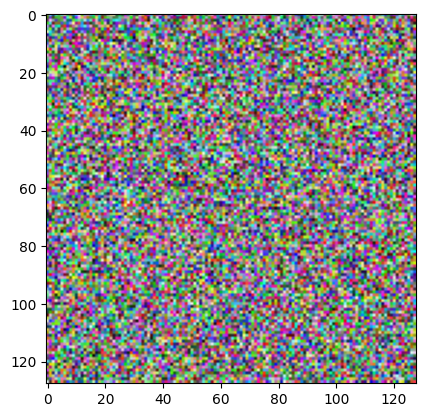

In [8]:
plt.imshow(cv2.cvtColor(hidden_img, cv2.COLOR_BGR2RGB))

In [17]:
def calculate_mse(original_img, hidden_img):
    """
    Orijinal görüntü ile gizlenmiş görüntü arasındaki piksel farklarının ortalaması
    Ne kadar küçük değer olursa o kadar iyi performans gösterir
    Eğer 0 ise iki görüntü birbirinin aynısıdır
    """
    mse = np.mean((original_img.astype(np.float32) - hidden_img.astype(np.float32)) **2)
    return mse

def calculate_psnr(original_img, hidden_img):
    """
    Orijinal görüntü ile gizlenmiş görüntü arasındaki benzerliği ölçer. Bozulma seviyesi hakkında bilgi verir.
    
    PSNR: > 30 --> Mükemmel kalite
    PSNR: 20-30 --> Kabul edilebilir
    PSNR: < 20 --> Görselde bozulma var
    """
    mse = calculate_mse(original_img, hidden_img)
    # if mse == 0:
    #     return "Original image and result image is the same"
    
    psnr = 10 * np.log10(255*255/mse)   # 255: 8 bit piksel değerleri arasındaki olabilecek en yüksek fark 
    return psnr

def calculate_ssim(original_img, hidden_img):
    """
    İnsan gözüne göre farkı değerlendirir
    0 (tam farklı) ile 1(tam benzer) arasında değerler verir
    Özellikle image-to-image için faydalı, yapısal bozulmayı ölçtüğü için
    text-to-image için metin az yer kapladığı için çok küçük farklar olabilir
    """
    if len(original_img.shape) == 3:
        return np.mean([ssim(original_img[:,:,i], hidden_img[:,:,i], data_range=255) for i in range(3)])
    else:
        return ssim(original_img, hidden_img, data_range=255)

def calculate_ber(original_bits, extracted_bits):
    """
    Gizli verinin çıkarıldıktan sonra ne kadarının hatalı olduğunu ölçer
    En anlamlı metriklerden biri bu alanda
    """
    min_len = min(len(original_bits), len(extracted_bits))
    errors = sum(o != e for o, e in zip(original_bits[:min_len], extracted_bits[:min_len]))
    return errors / min_len

def image_to_bits(image):
    return ''.join(format(byte, '08b') for byte in image.flatten())

def print_performance():
    # Görselleri yükle
    img_og_rgb = cv2.imread("input_data/lenna.png")
    img_og_gray = cv2.cvtColor(img_og_rgb, cv2.COLOR_BGR2GRAY)

    img_result_hi = cv2.imread("result_data/result_hi.png")
    img_result_hi_gray = cv2.imread("result_data/result_hi_gray.png", cv2.IMREAD_GRAYSCALE)

    img_result_img_to_img = cv2.imread("result_data/result_img_to_img.png")
    img_result_img_to_img_gray = cv2.imread("result_data/result_img_to_img_gray.png", cv2.IMREAD_GRAYSCALE)

    img_hidden_rgb = cv2.imread("input_data/random_rgb_128_128.png")
    img_hidden_gray = cv2.imread("input_data/random_gray_128_128.png", cv2.IMREAD_GRAYSCALE)

    # 64x64
    img_result_img_to_img_64_64 = cv2.imread("result_data/result_img_to_img_64_64.png")
    img_result_img_to_img_gray_64_64 = cv2.imread("result_data/result_img_to_img_gray_64_64.png", cv2.IMREAD_GRAYSCALE)

    # 64x64
    img_hidden_rgb_64_64 = cv2.imread("input_data/random_rgb_64_64.png")
    img_hidden_gray_64_64 = cv2.imread("input_data/random_gray_64_64.png", cv2.IMREAD_GRAYSCALE)

    # Extracted gizli img'leri tekrar oku
    img_extracted_rgb = cv2.imread("result_data/result_img_to_img.png")
    img_extracted_gray = cv2.imread("result_data/result_img_to_img_gray.png", cv2.IMREAD_GRAYSCALE)
    # 64x64
    img_extracted_rgb_64_64 = cv2.imread("result_data/result_img_to_img_64_64.png")
    img_extracted_gray_64_64 = cv2.imread("result_data/result_img_to_img_gray_64_64.png", cv2.IMREAD_GRAYSCALE)

    # img maymun

    img_maymun_og = cv2.imread("input_data/maymun.jpeg")
    img_result_maymun_lenna = cv2.imread("result_data/result_maymun_lenna.png")

    # # BER için bit dizileri
    bits_hidden_rgb = image_to_bits(img_hidden_rgb)
    bits_extracted_rgb = image_to_bits(img_extracted_rgb)

    bits_hidden_gray = image_to_bits(img_hidden_gray)
    bits_extracted_gray = image_to_bits(img_extracted_gray)

    # 64x64
    bits_hidden_rgb_64_64 = image_to_bits(img_hidden_rgb)
    bits_extracted_rgb_64_64 = image_to_bits(img_extracted_rgb)

    bits_hidden_gray_64_64 = image_to_bits(img_hidden_gray)
    bits_extracted_gray_64_64 = image_to_bits(img_extracted_gray)

    # bits_hidden_maymun_lenna = image_to_bits(img_og_rgb)
    # bits_extracted_maymun_lenna = image_to_bits(img_og_rgb)


    results = {
        "Text-to-Image (RGB)": {
            "PSNR": calculate_psnr(img_og_rgb, img_result_hi),
            "MSE": calculate_mse(img_og_rgb, img_result_hi),
            "SSIM": calculate_ssim(img_og_rgb, img_result_hi),
            "BER": "N/A"
        },
        "Text-to-Image (Gray)": {
            "PSNR": calculate_psnr(img_og_gray, img_result_hi_gray),
            "MSE": calculate_mse(img_og_gray, img_result_hi_gray),
            "SSIM": calculate_ssim(img_og_gray, img_result_hi_gray),
            "BER": "N/A"
        },
        "Image-to-Image (RGB)": {
            "PSNR": calculate_psnr(img_og_rgb, img_result_img_to_img),
            "MSE": calculate_mse(img_og_rgb, img_result_img_to_img),
            "SSIM": calculate_ssim(img_og_rgb, img_result_img_to_img),
            "BER": calculate_ber(bits_hidden_rgb, bits_extracted_rgb)
        },
        "Image-to-Image (Gray)": {
            "PSNR": calculate_psnr(img_og_gray, img_result_img_to_img_gray),
            "MSE": calculate_mse(img_og_gray, img_result_img_to_img_gray),
            "SSIM": calculate_ssim(img_og_gray, img_result_img_to_img_gray),
            "BER": calculate_ber(bits_hidden_gray, bits_extracted_gray)
        },
        "Image-to-Image (RGB) (64x64)": {
            "PSNR": calculate_psnr(img_og_rgb, img_result_img_to_img_64_64),
            "MSE": calculate_mse(img_og_rgb, img_result_img_to_img_64_64),
            "SSIM": calculate_ssim(img_og_rgb, img_result_img_to_img_64_64),
            "BER": calculate_ber(bits_hidden_rgb_64_64, bits_extracted_rgb_64_64)
        },
        "Image-to-Image (Gray) (64x64)": {
            "PSNR": calculate_psnr(img_og_gray, img_result_img_to_img_gray_64_64),
            "MSE": calculate_mse(img_og_gray, img_result_img_to_img_gray_64_64),
            "SSIM": calculate_ssim(img_og_gray, img_result_img_to_img_gray_64_64),
            "BER": calculate_ber(bits_hidden_gray_64_64, bits_extracted_gray_64_64)
        },
        "Image-to-Image (RGB) (maymunxlenna)": {
            "PSNR": calculate_psnr( img_maymun_og,img_result_maymun_lenna),
            "MSE": calculate_mse( img_maymun_og, img_result_maymun_lenna),
            "SSIM": calculate_ssim( img_maymun_og, img_result_maymun_lenna),
            # "BER": calculate_ber(bits_hidden_rgb_64_64, bits_extracted_rgb_64_64)
        },
    }

    # Tablo halinde göster
    df = pd.DataFrame(results).T.round(4)
    print(df)
#

In [18]:
print_performance()

                                          PSNR        MSE      SSIM       BER
Text-to-Image (RGB)                  90.752731   0.000055       1.0       N/A
Text-to-Image (Gray)                 28.572487  90.329926   0.98057       N/A
Image-to-Image (RGB)                 54.150851   0.250032  0.998073  0.499858
Image-to-Image (Gray)                28.545492  90.893143   0.97855  0.499672
Image-to-Image (RGB) (64x64)          60.15604    0.06273  0.999412  0.499858
Image-to-Image (Gray) (64x64)        28.567471  90.434326  0.979906  0.499672
Image-to-Image (RGB) (maymunxlenna)  62.615399   0.035607  0.999683       NaN
